In [96]:
# Homework 2 Question 2
# This code was adapted from the starter code supplied

""" Solve
u_t + (u^2 / 2)_x = 0 on [-1, 6]
with fixed boundary conditions.
"""

' Solve\nu_t + (u^2 / 2)_x = 0 on [-1, 6]\nwith fixed boundary conditions.\n'

In [97]:
import numpy as np
import matplotlib.pyplot as plt


In [98]:
# Initial Conditions
def step(x):
    u = np.zeros(x.shape)
    for j in range(len(x)):
        if x[j] < 0:
            u[j] = 2.0
        elif (x[j] >= 0) and (x[j] <= 1):
            u[j] = 2.0 - x[j]
        else:
            u[j] = 1.0
    return u

# Exact Rarefaction
def exact_rarefaction(x, t):
    u = np.zeros_like(x)
    if t < 1:
        u[x < 2*t] = 2.0
        mask_linear = (x >= 2*t) & (x <= 1+t)
        u[mask_linear] = (2 - x[mask_linear])/(1-t)
        u[x > 1+t] = 1.0
    else:
        x_s = 2 + 1.5*(t-1)
        u[x < x_s] = 2.0
        u[x >= x_s] = 1.0
    return u

end_time = 2.0
gamma = 0.01 # I changed this from the one in the starter code of 0.9 as that did not satisfy the CFL condition
nx = 128
x, hx = np.linspace(-1, 6, nx, endpoint=False, retstep=True)
# Ghost cell mask: pretend first and last DoF are ghost cells
mask = np.ones(len(x), dtype=bool)
mask[:1] = mask[-1:] = False
# Indexing arrays
K = np.arange(0, nx)    # 0, ..., nx-1
Km1 = np.roll(K, 1)     # nx-1, 0, 1, ..., nx-2
Kp1 = np.roll(K, -1)    # 1, ..., nx

ht = hx * gamma
nt = int(np.ceil(end_time / ht))
ht = end_time / nt

print('T = %g' % end_time)
print('tsteps = %d' % nt)
print('    hx = %g' % hx)
print('    ht = %g' % ht)
print('lambda = %g' % gamma)

u = step(x)
u0 = u.copy()

def f(u):
    return 0.5 * u**2

def fprime(u):
    return u

T = 2
tsteps = 3658
    hx = 0.0546875
    ht = 0.000546747
lambda = 0.01


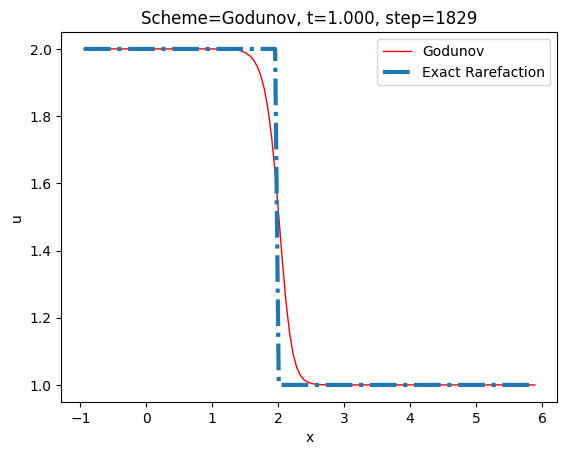

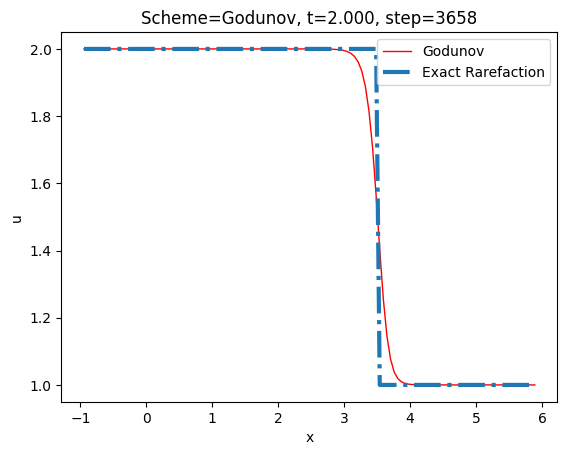

In [99]:

def flux_LLF(uL, uR):
    alpha = max(abs(fprime(uL)), abs(fprime(uR)))
    return 0.5 * (f(uL) + f(uR)) - 0.5 * alpha * (uR - uL)

# --- Updated Godunov flux (Equation (6.72)) --- #
def flux_godunov(uL, uR):
    if uL <= uR:
        return min(f(uL), f(uR))
    elif uL > uR:
        return max(f(uL), f(uR))

# --- Updated LLF flux (Equation (6.59, 6.60, 6.61)) --- #
def update_LLF(u, hx, ht):
    nx = len(u)
    unew = u.copy()
    F = np.zeros(nx + 1)

    for j in range(nx - 1):
        F[j+1] = flux_LLF(u[j], u[j+1])

    for j in range(1, nx - 1):
        unew[j] = u[j] - (ht / hx) * (F[j+1] - F[j])

    unew[0] = 2.0
    unew[-1] = 1.0
    return unew

def update_Godunov(u, hx, ht):
    nx = len(u)
    unew = u.copy()
    F = np.zeros(nx + 1)

    # If you actually want Godunov fluxes, call flux_godunov here:
    for j in range(nx - 1):
        F[j+1] = flux_godunov(u[j], u[j+1])
        # Or compare by using flux_LLF(u[j], u[j+1]) if desired

    for j in range(1, nx - 1):
        unew[j] = u[j] - (ht / hx) * (F[j+1] - F[j])

    unew[0] = 2.0
    unew[-1] = 1.0
    return unew

# --- Minmod Slope Limiter (Equation (6.106)) --- #
def minmod(r):
    return max(0.0, min(1.0, r))

def spatial_reconstruct_minmod(u, hx):
    """
    Compute minmod-limited slopes for each cell using ratio r,
    then return arrays of left- and right-interface values.
    """
    nx = len(u)
    slope = np.zeros(nx)

    # Compute the slope in each interior cell via r-based minmod
    for j in range(1, nx - 1):
        # Right difference
        dr = (u[j+1] - u[j]) / hx
        # Left difference
        dl = (u[j] - u[j-1]) / hx

        # Avoid dividing by zero
        if abs(dr) < 1.0e-14:
            slope[j] = 0.0
        else:
            r = dl / dr
            slope[j] = minmod(r) * dr

    # Build left/right interface values
    uL = np.zeros(nx)  # left interface
    uR = np.zeros(nx)  # right interface

    # Initialize to cell averages
    for j in range(nx):
        uL[j] = u[j]
        uR[j] = u[j]

    # Now overwrite interior with piecewise linear reconstructions
    for j in range(1, nx - 1):
        uR[j] = u[j] + 0.5 * hx * slope[j]  # value at right edge of cell j
        uL[j] = u[j] - 0.5 * hx * slope[j]  # value at left edge of cell j

    return uL, uR


def L_operator_LLF(u, hx):
    """
    Compute the spatial derivative operator L(u) for Burgers
    using LLF flux on the piecewise linear reconstructions.
    """
    # Enforce ghost cell values for consistency before flux calc
    u[0]  = 2.0
    u[-1] = 1.0

    # Reconstruct using the ratio-based minmod
    uL, uR = spatial_reconstruct_minmod(u, hx)

    nx_local = len(u)
    F = np.zeros(nx_local + 1)

    # Compute interface fluxes
    for j in range(nx_local):
        if j + 1 < nx_local:
            # interface j+1/2 => left state = uR[j], right state = uL[j+1]
            F[j+1] = flux_LLF(uR[j], uL[j+1])

    # Build L(u)
    Lu = np.zeros_like(u)
    for j in range(1, nx_local - 1):
        Lu[j] = -(1.0 / hx) * (F[j+1] - F[j])

    # Keep boundary L(u) = 0 to hold them fixed
    Lu[0]  = 0.0
    Lu[-1] = 0.0
    return Lu

def update_RK2(u, hx, ht):
    """
    Second-order TVD Runge-Kutta (Heun or midpoint) method
    with minmod-limited reconstruction and LLF flux.
    """
    # Stage 1
    k1 = L_operator_LLF(u.copy(), hx)
    u_star = u + ht*k1

    # Stage 2
    k2 = L_operator_LLF(u_star.copy(), hx)
    unew = u + ht*k2

    # Final boundary enforcement
    unew[0]  = 2.0
    unew[-1] = 1.0
    return unew

scheme = "Godunov"  # Choose "LLF", "Godunov", or "RK2"

for n in range(2, nt + 1):
    time = n * ht

    if scheme == "LLF":
        u = update_LLF(u, hx, ht)
    elif scheme == "Godunov":
        u = update_Godunov(u, hx, ht)
    elif scheme == "RK2":
        u = update_RK2(u, hx, ht)
    else:
        raise ValueError("Unknown scheme '%s'." % scheme)

    uexact = exact_rarefaction(x, time)

    # Plot at T=1 or T=2
    if abs(time - 1.) < ht/2 or abs(time - 2.) < ht/2:
        plt.figure()
        plt.title(f'Scheme={scheme}, t={time:.3f}, step={n}')
        plt.plot(x[mask], u[mask], 'r-', linewidth=1, label=scheme)
        plt.plot(x[mask], uexact[mask], '-.', linewidth=3, label='Exact Rarefaction')
        plt.xlabel('x')
        plt.ylabel('u')
        plt.legend()
        plt.show()

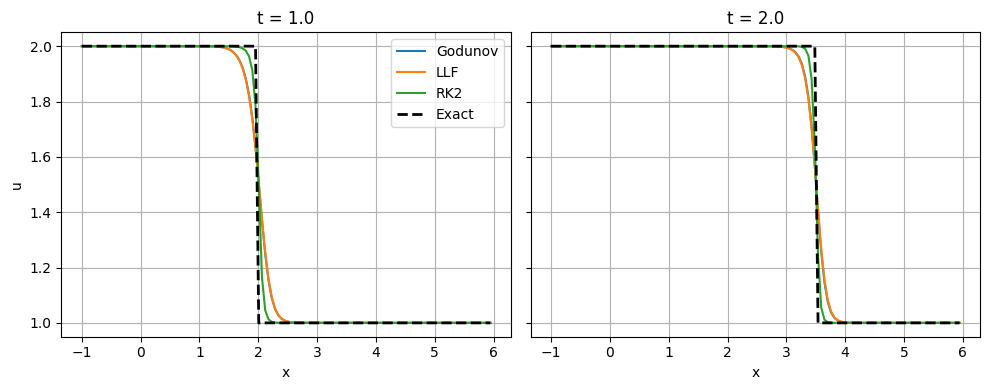

In [100]:
def solve_scheme(scheme, end_time, gamma, nx):
    """
    Solve the Burgers equation from t=0 to t=end_time using
    the chosen 'scheme' ('LLF', 'Godunov', or 'RK2').
    Returns:
       x, u_t1, u_t2  (the grid and solutions at t=1 and t=2)
    """
    x, hx = np.linspace(-1, 6, nx, endpoint=False, retstep=True)
    u = step(x)  # initial condition
    # Setup time step based on CFL-like factor gamma
    ht = gamma * hx
    nt = int(np.ceil(end_time / ht))
    ht = end_time / nt  # recompute dt so we land exactly on end_time

    # We will store solution at T=1 and T=2
    u_t1 = None
    u_t2 = None

    for n in range(1, nt+1):
        t = n * ht

        # Update depending on the scheme
        if scheme == "LLF":
            u = update_LLF(u, hx, ht)
        elif scheme == "Godunov":
            u = update_Godunov(u, hx, ht)
        elif scheme == "RK2":
            u = update_RK2(u, hx, ht)
        else:
            raise ValueError("Unknown scheme '%s'." % scheme)

        # Save the solution at T=1
        if abs(t - 1.0) < 1e-12 or (t > 1.0 and u_t1 is None):
            # We'll just store it the first time t crosses 1.0
            u_t1 = u.copy()

        # Save the solution at T=2
        if abs(t - 2.0) < 1e-12 or (t > 2.0):
            u_t2 = u.copy()
            break

    return x, u_t1, u_t2


schemes = ["Godunov", "LLF", "RK2"]

# Dictionary to hold solutions at T=1 and T=2 for each scheme
solutions = {}
for s in schemes:
    x, sol_t1, sol_t2 = solve_scheme(scheme=s, end_time=end_time, gamma=gamma, nx=nx)
    solutions[s] = (sol_t1, sol_t2)

# Prepare exact solutions at T=1 and T=2
exact_t1 = exact_rarefaction(x, 1.0)
exact_t2 = exact_rarefaction(x, 2.0)

# Make a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# --- Left subplot: T=1 ---
ax = axes[0]
ax.set_title("t = 1.0")
for s in schemes:
    ax.plot(x, solutions[s][0], label=s)
ax.plot(x, exact_t1, 'k--', linewidth=2, label='Exact')
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.legend(loc='best')
ax.grid(True)

# --- Right subplot: T=2 ---
ax = axes[1]
ax.set_title("t = 2.0")
for s in schemes:
    ax.plot(x, solutions[s][1],  label=s)
ax.plot(x, exact_t2, 'k--', linewidth=2, label='Exact')
ax.set_xlabel('x')
ax.grid(True)

plt.tight_layout()
plt.show()